# CPSC 368 Impact By Disease (KNM Neighbours)

In [1]:
import oracledb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display

In [2]:
# INPUT USER INFO HERE
CWL = ""
studentnum = ""

In [3]:
# Acquire data
dsn = oracledb.makedsn("localhost", 1522, service_name="stu")
connection = oracledb.connect(user=f"ora_{CWL}", password=f"a{studentnum}", dsn=dsn)
cur = connection.cursor()

try:
    # SQL code
    cur.execute(
        """
        SELECT 
            us."LocationDesc" AS State,
        CASE 
            WHEN us."DataValueUnit" = 'cases per 100,000' THEN 'per 100,000'
            ELSE us."DataValueUnit" 
        END AS DeathRateUnit,
        us."DataValueType" AS DeathRateType,
        us."DataValue" AS AvgDeathRate,
        us."Stratification1",
        us."Question" AS QUESTION,
        us."DataValue",
        us."Topic" AS Disease,
        kff.All_Uninsured
        FROM USCDI_filter us
        LEFT JOIN KFF2019_new kff
            ON us."LocationDesc" = kff.Location
        WHERE us."LocationDesc" IN ('Texas', 'Massachusetts')
            AND us."Topic" IN ('Cardiovascular Disease', 'Cancer')
            AND us."DataValueUnit" IN ('cases per 100,000', 'per 100,000')
            AND us."DataValueType" = 'Crude Rate'
            AND us."Stratification1" = 'Overall'

        """
    )
    
    # Fetch SELECT results 
    rows = cur.fetchall()
    
    # Get column names from cursor
    columns = [desc[0] for desc in cur.description]
    
    # Create DataFrame
    USCDI_final = pd.DataFrame(rows, columns=columns)
    
    print("Completed dataframe.")
except Exception as e:
    print(f"Error executing SQL query: {e}")
finally: 
    cur.close()
    connection.close()

Completed dataframe.


In [4]:
USCDI_final.head()

,STATE,DEATHRATEUNIT,DEATHRATETYPE,AVGDEATHRATE,Stratification1,QUESTION,DataValue,DISEASE,ALL_UNINSURED
0,Massachusetts,"per 100,000",Crude Rate,573.6,Overall,"Invasive cancer (all sites combined), incidence",573.6,Cancer,0.044
1,Massachusetts,"per 100,000",Crude Rate,45.0,Overall,Lung and bronchial cancer mortality among all ...,45.0,Cancer,0.044
2,Massachusetts,"per 100,000",Crude Rate,14.0,Overall,Colon and rectum (colorectal) cancer mortality...,14.0,Cancer,0.044
3,Massachusetts,"per 100,000",Crude Rate,43.4,Overall,Lung and bronchial cancer mortality among all ...,43.4,Cancer,0.044
4,Massachusetts,"per 100,000",Crude Rate,561.6,Overall,"Invasive cancer (all sites combined), incidence",561.6,Cancer,0.044


After reading the data file, we see that it contains 309,215 observations and 13 attributes. Further analysis, including checking for missing values, will be conducted later, as filtering needs to be applied to finalize the dataset.

In [5]:
USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Cervical cancer mortality among all females, underlying cause': 
     'Cervical cancer'})

USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Invasive cancer (all sites combined) mortality among all people, underlying cause': 
     'Invasive cancer'})

USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Breast cancer mortality among all females, underlying cause': 
     'Breast cancer'})

USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Colon and rectum (colorectal) cancer mortality among all people, underlying cause': 
     'Colorectal cancer'})

USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Lung and bronchial cancer mortality among all people, underlying cause': 
     'Lung cancer'})

USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Prostate cancer mortality among all males, underlying cause': 
     'Prostate cancer'})

USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Coronary heart disease mortality among all people, underlying cause': 
     'Coronary heart disease'})

USCDI_final = USCDI_final[USCDI_final['QUESTION'].isin(['Cervical cancer', 'Breast cancer',
                                                        'Colorectal cancer', 'Prostate cancer',
                                                       'Lung cancer', 'Coronary heart disease'])]

USCDI_final.rename(columns={'QUESTION': 'TYPE'}, inplace=True)

We selected the necessary attributes to answer this question specifically and renamed some attributes for clarity. Note that we excluded invasive cancer because it is too broad—it includes many different types of "invasive" cancer, making it unsuitable for analyzing the impact of specific cancer types.

In [6]:
USCDI_final.isnull().sum()

STATE              0
DEATHRATEUNIT      0
DEATHRATETYPE      0
AVGDEATHRATE       0
Stratification1    0
TYPE               0
DataValue          0
DISEASE            0
ALL_UNINSURED      0
dtype: int64

The attributes needed does not contain missing values, therefore imputation is unnecessary.

In [7]:
CHD = USCDI_final[
    (USCDI_final['DISEASE'] == "Cardiovascular Disease")]

CANCER = USCDI_final[USCDI_final['DISEASE'] == "Cancer"]

Since we are examining coronary heart disease and cancer, the dataset is divided into two subsets.

In [8]:
CHD

,STATE,DEATHRATEUNIT,DEATHRATETYPE,AVGDEATHRATE,Stratification1,TYPE,DataValue,DISEASE,ALL_UNINSURED
16,Massachusetts,"per 100,000",Crude Rate,84.0,Overall,Coronary heart disease,84.0,Cardiovascular Disease,0.044
20,Massachusetts,"per 100,000",Crude Rate,82.6,Overall,Coronary heart disease,82.6,Cardiovascular Disease,0.044
21,Massachusetts,"per 100,000",Crude Rate,82.6,Overall,Coronary heart disease,82.6,Cardiovascular Disease,0.044
38,Texas,"per 100,000",Crude Rate,88.3,Overall,Coronary heart disease,88.3,Cardiovascular Disease,0.245
40,Texas,"per 100,000",Crude Rate,93.2,Overall,Coronary heart disease,93.2,Cardiovascular Disease,0.245
45,Texas,"per 100,000",Crude Rate,96.0,Overall,Coronary heart disease,96.0,Cardiovascular Disease,0.245


In [9]:
CANCER

,STATE,DEATHRATEUNIT,DEATHRATETYPE,AVGDEATHRATE,Stratification1,TYPE,DataValue,DISEASE,ALL_UNINSURED
1,Massachusetts,"per 100,000",Crude Rate,45.0,Overall,Lung cancer,45.0,Cancer,0.044
2,Massachusetts,"per 100,000",Crude Rate,14.0,Overall,Colorectal cancer,14.0,Cancer,0.044
3,Massachusetts,"per 100,000",Crude Rate,43.4,Overall,Lung cancer,43.4,Cancer,0.044
5,Massachusetts,"per 100,000",Crude Rate,1.4,Overall,Cervical cancer,1.4,Cancer,0.044
8,Massachusetts,"per 100,000",Crude Rate,22.8,Overall,Breast cancer,22.8,Cancer,0.044
9,Massachusetts,"per 100,000",Crude Rate,1.4,Overall,Cervical cancer,1.4,Cancer,0.044
10,Massachusetts,"per 100,000",Crude Rate,22.7,Overall,Breast cancer,22.7,Cancer,0.044
11,Massachusetts,"per 100,000",Crude Rate,19.1,Overall,Prostate cancer,19.1,Cancer,0.044
12,Massachusetts,"per 100,000",Crude Rate,14.2,Overall,Colorectal cancer,14.2,Cancer,0.044
13,Massachusetts,"per 100,000",Crude Rate,19.5,Overall,Prostate cancer,19.5,Cancer,0.044


In terms of outliers, it is not necessary since we do not have a lot of observations. Therefore in order to maintain information, outlier detection and removal is ignored. 

A summary table for different types of cancer with descriptive statistics is provided for both states.

In [10]:
CANCER.groupby(["STATE","TYPE"])["AVGDEATHRATE"].agg(["mean","std","min","max","count"])

mean       std   min   max  count
STATE         TYPE                                                 
Massachusetts Breast cancer      22.75  0.070711  22.7  22.8      2
              Cervical cancer     1.40  0.000000   1.4   1.4      2
              Colorectal cancer  14.10  0.141421  14.0  14.2      2
              Lung cancer        44.20  1.131371  43.4  45.0      2
              Prostate cancer    19.30  0.282843  19.1  19.5      2
Texas         Breast cancer      21.10  0.000000  21.1  21.1      2
              Cervical cancer     2.90  0.000000   2.9   2.9      2
              Colorectal cancer  13.70  0.000000  13.7  13.7      2
              Lung cancer        31.45  0.494975  31.1  31.8      2
              Prostate cancer    13.85  0.212132  13.7  14.0      2

## Visualizations

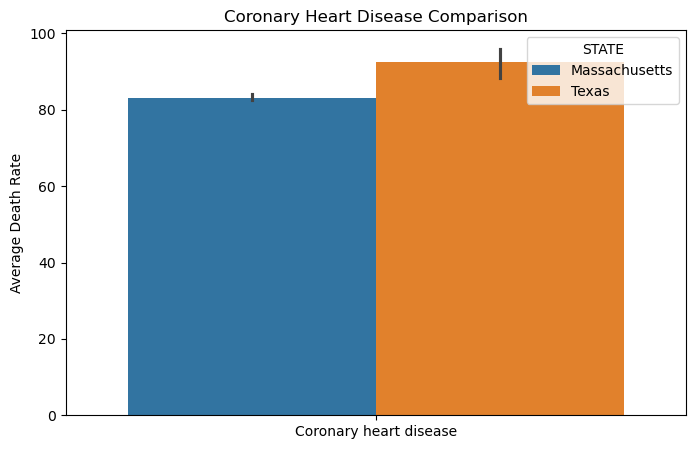

In [11]:
plt.figure(figsize=(8, 5))
sns.barplot(data= CHD, x='TYPE', y='AVGDEATHRATE', hue='STATE')
plt.xlabel('')
plt.ylabel('Average Death Rate')
plt.title('Coronary Heart Disease Comparison')
plt.legend(title='STATE')
plt.show()

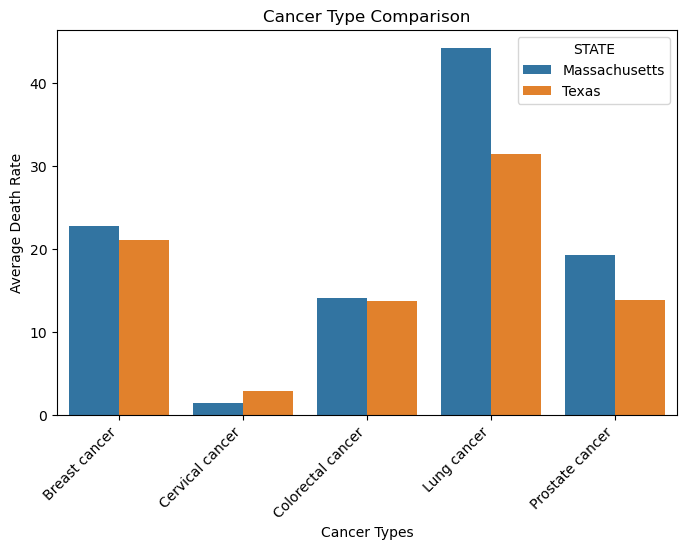

In [12]:
eda_summary_cancer = CANCER.groupby(['STATE', 'TYPE'])['AVGDEATHRATE'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=eda_summary_cancer, x='TYPE', y='AVGDEATHRATE', hue='STATE')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Cancer Types')
plt.ylabel('Average Death Rate')
plt.title('Cancer Type Comparison')
plt.legend(title='STATE')
plt.show()